# CP467: Course Project
Chandler Mayberry (190688910) - Samson Goodenough (190723380)

In [1]:
# imports
import numpy as np
import cv2
from cv2 import Stitcher
import matplotlib.pyplot as plt
import os

## Preparing Objects
Load all object images and assign them names.

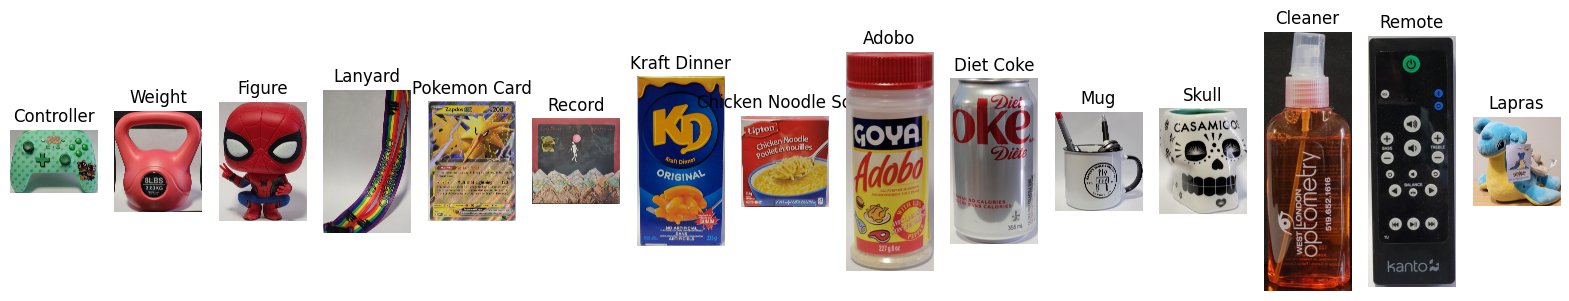

In [2]:
OBJECT_NAMES = {
  "O1.png": "Controller",
  "O2.png": "Chicken Noodle Soup",
  "O3.png": "Adobo",
  "O4.png": "Diet Coke",
  "O5.png": "Mug",
  "O6.png": "Skull",
  "O7.png": "Cleaner",
  "O8.png": "Remote",
  "O9.png": "Lapras",
  "O10.png": "Weight",
  "O11.png": "Figure",
  "O12.png": "Lanyard",
  "O13.png": "Pokemon Card",
  "O14.png": "Record",
  "O15.png": "Kraft Dinner"
}

# load in all of the images
objects = []

# use os to get all of the files in the directory
for file in os.listdir("../Objects/"):
  # read in the image
  img = cv2.imread("../Objects/" + file)
  # convert to correct color
  fixed = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # append to the list
  objects.append({"name": OBJECT_NAMES[file], "image": fixed, "id": file[:-4]})


# plot the images
plt.figure(figsize=(20, 20))
for i in range(len(objects)):
  # plot each with no axis and filename as title
  plt.subplot(1, len(objects), i+1)
  plt.imshow(objects[i]["image"])
  plt.axis("off")
  plt.title(objects[i]["name"])
plt.show()


## Preparing Scenes
Load all scene images and group them into the different stitchable scenes.

| Group # | Scenes    |
|---------|-----------|
| Group 1 | S1 - S6   |
| Group 2 | S7        |
| Group 3 | S8 - S14  |
| Group 4 | S15 - S19 |
| Group 5 | S20 - S21 |

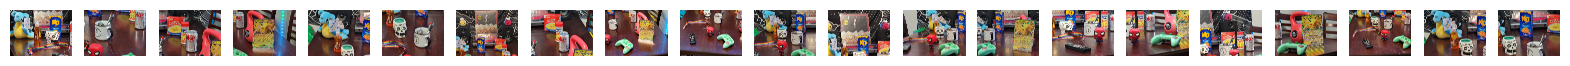

In [3]:
# load in all of the images
scenes = {}
groups = {
  "group_1": [],
  "group_2": [],
  "group_3": [],
  "group_4": [],
  "group_5": []
}
GROUP_LOOKUP = {
  "group_1": ["S1.png", "S2.png", "S3.png", "S4.png", "S5.png", "S6.png"],
  "group_2": ["S7.png"],
  "group_3": ["S8.png", "S9.png", "S10.png", "S11.png", "S12.png"],
  "group_4": ["S15.png", "S16.png", "S17.png", "S18.png", "S19.png"],
  "group_5": ["S20.png", "S21.png"]
}

# use os to get all of the files in the directory
for file in os.listdir("../Scenes/"):
  # read in the image
  img = cv2.imread("../Scenes/" + file)
  # convert to correct color
  fixed = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  # append to the list
  scenes[file] = fixed
  # find file name in group lookup
  for key in GROUP_LOOKUP:
    if file in GROUP_LOOKUP[key]:
      groups[key].append(fixed)

# plot the images
plt.figure(figsize=(20, 20))
for i, key in enumerate(scenes):
  # plot each with no axis and filename as title
  plt.subplot(1, len(scenes), i+1)
  plt.imshow(scenes[key])
  plt.axis("off")
plt.show()


## Running All Tests ##

In [4]:

def summarize_images(key, scene, objects, object_keypoints, object_descriptors, min_matches = 28, threshold = 0.7):

    #The boxed and scenes containing all of the keypoints need to survive on each iteration:
    boxes_output_scene = scene.copy()
    keypoints_output_scene = scene.copy()

    for i, curr_obj in enumerate(objects):
        raw_scene = scene.copy() #for the matching output (need raw scene everytime to match individual objects)
        sift_instance = cv2.SIFT_create()
        
        obj_keypoints = object_keypoints[i]
        obj_descriptors = object_descriptors[i]
        scene_keypoints, scene_descriptors = sift_instance.detectAndCompute(raw_scene, None)
        
        #https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
        brute_force_matcher = cv2.BFMatcher()
        matches = brute_force_matcher.knnMatch(obj_descriptors, scene_descriptors, k=2)

        #Check to see what matches out of them are within the predefined threshold (overall closeness)
        close_matches = []
        close_matches_nonlist = []

        for m, n in matches:
            if m.distance < threshold*n.distance:
                close_matches.append([m])
                close_matches_nonlist.append(m)

        if len(close_matches) >= min_matches:
             
            #decrease the total number of matches to optimize the runtime below
            close_matches = close_matches[:80]
            close_matches_nonlist = close_matches_nonlist[:80]

            boxes_output_scene = boxes(boxes_output_scene, curr_obj, obj_keypoints, scene_keypoints, close_matches_nonlist)
            keypoints_output_scene = all_keypoints_on_scene(keypoints_output_scene, scene_keypoints, close_matches)
            matching(key, raw_scene, curr_obj, scene_keypoints, close_matches)            


    #this write is for the output with boxes + color fixing
    boxes_output_scene = cv2.cvtColor(boxes_output_scene, cv2.COLOR_BGR2RGB) 
    cv2.imwrite(f"../Detected_Objects/{key}_detected.png", boxes_output_scene)

    #this write is for the output with all keypoints for scene + color fixing
    keypoints_output_scene = cv2.cvtColor(keypoints_output_scene, cv2.COLOR_BGR2RGB) 
    cv2.imwrite(f"../Keypoints/{key}_keypoints.png", keypoints_output_scene)
    
    
    return



"""
Shows each object detected in the scene in a labelled box.
"""
#here we want to return the scene as we want to write over it on every iteration
def boxes(boxes_output_scene, curr_obj, obj_keypoints, scene_keypoints, close_matches_nonlist):

    # https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

    curr_obj_image = curr_obj["image"]

    # draw box around detected image
    object_points = np.float32([ obj_keypoints[m.queryIdx].pt for m in close_matches_nonlist ]).reshape(-1, 1, 2)
    scene_points = np.float32([ scene_keypoints[m.trainIdx].pt for m in close_matches_nonlist ]).reshape(-1, 1, 2)
    mask, _ = cv2.findHomography(object_points, scene_points, cv2.RANSAC, 5.0)
    height, width, _ = curr_obj_image.shape
    points = np.float32([ [0, 0], [0, height-1], [width-1, height-1], [width-1, 0] ]).reshape(-1, 1, 2)
    scene = cv2.perspectiveTransform(points, mask)
    boxes_output_scene = cv2.polylines(boxes_output_scene,[np.int32(scene)], True, 255, 3, cv2.LINE_AA)


    # label all of the scene objects
    # https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga5126f47f883d730f633d74f07456c576
    cv2.putText(img=boxes_output_scene, text=curr_obj['name'], org=(int(scene[0][0][0]), int(scene[1][0][1])), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=3, color=(0, 0, 0), thickness=4, lineType=cv2.FILLED, bottomLeftOrigin = False)
    
    return boxes_output_scene


"""
Gets all of the keypoints from all objects in each scene and for each objects and saves each object/scene individually with keypoints shown.
"""
#this we want to be returning the scene as we want to write the keypoints of all of the objects onto the single scene
def all_keypoints_on_scene(keypoints_output_scene, scene_keypoints, close_matches):

    keypoints_output_scene = cv2.drawKeypoints(keypoints_output_scene, scene_keypoints, None, color=(0, 0, 255))

    for match in close_matches:
        keypoints_output_scene = cv2.circle(keypoints_output_scene, (int(scene_keypoints[match[0].trainIdx].pt[0]), int(scene_keypoints[match[0].trainIdx].pt[1])), 10, (255, 0, 0), 3)
            
    return keypoints_output_scene


#this method needs to be separate as we dont want to do this everytime in the above code.
def all_keypoints_on_objects(objects):

    object_keypoints = []
    object_descriptors = []

    for current_object in objects:
        sift_instance = cv2.SIFT_create()

        train_object = current_object["image"]
        keypoint, descriptors = sift_instance.detectAndCompute(train_object, None)
        copy_obj = train_object.copy()

        object_keypoints.append(keypoint)
        object_descriptors.append(descriptors)

        copy_obj = cv2.drawKeypoints(copy_obj, keypoint, None)
        copy_obj = cv2.cvtColor(copy_obj, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"../Keypoints/{current_object['id']}_keypoints.png", copy_obj)
 
    return object_keypoints, object_descriptors



"""
Shows the keypoints for every object individually on each scene. Each scene has multiple outputs to show keypoints for each object.
The object is shown on the right of each scene to denote the keypoints being shown in scene.
"""
#this one we are just saving every scene with keypoints on each specific object.
def matching(key, raw_scene, curr_obj, scene_keypoints, close_matches):
    
    curr_obj_image = curr_obj["image"]
            
    for match in close_matches:
        cv2.circle(raw_scene, (int(scene_keypoints[match[0].trainIdx].pt[0]), int(scene_keypoints[match[0].trainIdx].pt[1])), 10, (255, 0, 0), 3)

    curr_obj_image = cv2.resize(curr_obj_image, (0, 0), fx=0.5, fy=0.5)
    
    height = max(raw_scene.shape[0], curr_obj_image.shape[0])
    width = raw_scene.shape[1] + curr_obj_image.shape[1]
    
    combined_image = np.zeros((height, width, 3), dtype=np.uint8)
    
    combined_image[:raw_scene.shape[0], :raw_scene.shape[1]] = raw_scene
    combined_image[:curr_obj_image.shape[0], raw_scene.shape[1]:] = curr_obj_image
    
    # fix color before saving
    combined_image = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(f"../Matches/{key}_{curr_obj['id']}_matches.png", combined_image)

    return



#get the keypoints and the object descriptors for all objects to increase performance
object_keypoints, object_descriptors = all_keypoints_on_objects(objects)

#run all instances
result = []
for key in scenes:
    result.append(summarize_images(key[:-4], scenes[key], objects, object_keypoints, object_descriptors)) #key[:-4] for file naming


## Image Stitching

Could not stitch group_4


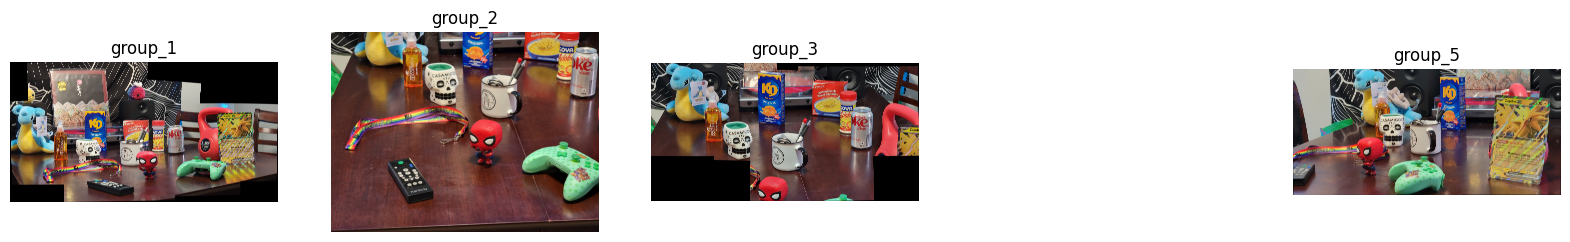

In [5]:
# create stitcher object
stitcher = Stitcher.create()

# start figure
plt.figure(figsize=(20, 20))

# loop through all of the image groups
for key in groups:
  # get the images
  images = groups[key]
  
  if len(images) > 1:
    # stitch images
    _, result = stitcher.stitch(images)
  else:
    result = images[0]
  
  if result is None:
    print(f"Could not stitch {key}")
    continue
  
  # fix color before saving
  result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
  
  # pass result through boxes function to detect objects
  result = boxes(result, objects, object_keypoints, object_descriptors)
  
  # save stitched image
  cv2.imwrite(f"../Stitched/{key}.png", result)
  # plot the stitched image
  plt.subplot(1, len(groups), int(key[-1]))
  plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.title(key)

plt.show()